In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import os
import glob
import cv2
from subprocess import call
import scipy.io as scio
from func_util_geom import *
import scipy.optimize as scop
import copy

In [2]:
seqname = 'Antw_02_1_SfM_01_fr7340-7640'
#seqname = 'Antw_01_1_SfM_01_fr5650-5950'
#seqname = 'Antw_08_2_SfM_01_fr6300-6600'
#seqname = 'Antw_08_2_SfM_01_fr16300-16600'

dpath = '/home/kroegert/local/Datasets/GeoAutomation_Antwerpen'
outpath = '/home/kroegert/local/Results/VehicleTrack/'
acam = scio.loadmat(dpath + '/' + seqname + '/' + seqname + '.mat') 

Kr_l = []
kc_l = []
Rr_l = []
tr_l = []
wh_l = []
nocams = 12
for i in xrange(nocams):
    Kr_l.append(acam['cameras'][0][i]['K'].astype(float))
    tr_l.append(acam['cameras'][0][i]['t'][:,0].astype(float))
    kc = acam['cameras'][0][i]['k'][0].astype(float)    
    kc_l.append(np.array([kc[0], kc[1], 0.0, 0.0, kc[2]]))
    Rr_l.append(acam['cameras'][0][i]['R'].astype(float))    
    wh_l.append(np.array([acam['cameras'][0][i]['w'][0][0].astype(float), 
                          acam['cameras'][0][i]['h'][0][0].astype(float)]))
    
    # Fix rot.  matrices. May by fully orthonormal
    U,s,V = np.linalg.svd(Rr_l[-1])
    Rr_l[-1] = np.dot(U, V)
    Rr_l[-1] = Rr_l[-1].T
    #print np.linalg.det(Rr_l[-1])

R_glob = acam['poses'][0]['R'][0].astype(float)
t_glob = acam['poses'][0]['t'][0].astype(float)
# Fix rot.  matrices. May by fully orthonormal
for i in xrange(R_glob.shape[2]):
    U,s,V = np.linalg.svd(R_glob[:,:,i])
    R_glob[:,:,i] = np.dot(U, V)
    #R_glob[:,:,i] = R_glob[:,:,i].T
    
# normalize positions    
t_glob -= np.mean(t_glob, axis=1)[:,None]

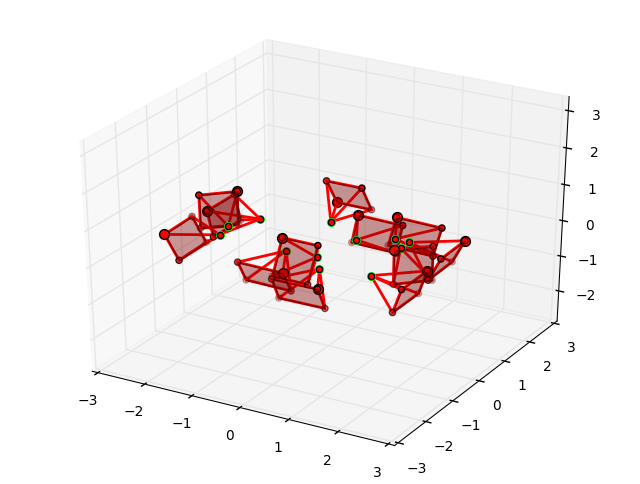

In [3]:
# Plot camera configuration
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
for i in xrange(nocams):
    fc = np.array([Kr_l[i][0,0], Kr_l[i][1,1]])
    wh = wh_l[i]
    cc = np.array([Kr_l[i][0,2], Kr_l[i][1,2]])-wh/2.0    
    ax.scatter(tr_l[i][0], tr_l[i][1], tr_l[i][2], color=np.array([0.0,1.0,0.0]), linewidth=2)
    func_plot_cameras(ax, fc, cc, wh, Rr_l[i], tr_l[i], rgbface=np.array([1.0,0,0]), camerascaling=1)
func_set_axes_equal(ax)
plt.show()

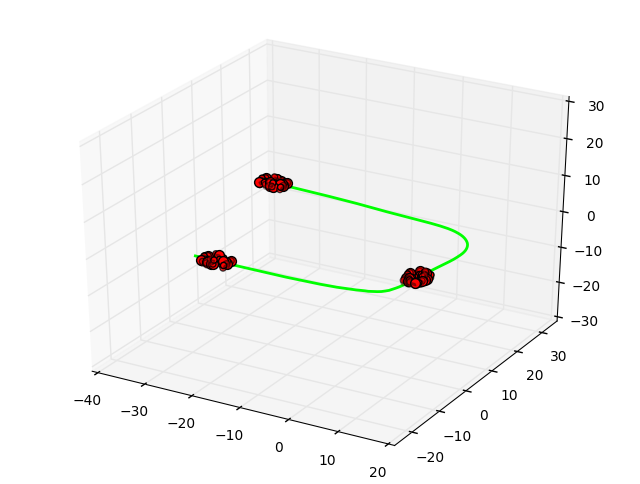

In [4]:
# Visualize vehicle poses with cameras
frinit = 145 # use N frames for initialization of van pose, afterwards update pose from 3D points
maxfr = R_glob.shape[2]

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')


for fr in xrange(0, maxfr, frinit):    
    for i in xrange(nocams):
        fc = np.array([Kr_l[i][0,0], Kr_l[i][1,1]])
        wh = wh_l[i]
        cc = np.array([Kr_l[i][0,2], Kr_l[i][1,2]])-wh/2.0    
        R =  np.dot(Rr_l[i], R_glob[:,:,fr].T)
        t = t_glob[:,[fr]] + np.dot(R_glob[:,:,fr], tr_l[i][:,None])
        t = t[:,0]
        func_plot_cameras(ax, fc, cc, wh, R, t, rgbface=np.array([1.0,0,0]), camerascaling=1)

ax.plot(t_glob[0, 0:maxfr], t_glob[1,0:maxfr], t_glob[2,0:maxfr], color=np.array([0.0,1.0,0.0]), linewidth=2)
            
func_set_axes_equal(ax)
plt.show()



In [5]:
# Load tracks, undistort
track_l_org = []  # original distorted
track_l = [] # undistorted
for i in xrange(nocams):
    camnp = '%02i' % i
    a = np.load(outpath + seqname + "_" + camnp + "_tracks.npz")['x']
    track_l_org.append(copy.deepcopy(a))

    # undistort point trajectories
    fc = np.array([Kr_l[i][0,0], Kr_l[i][1,1]])
    cc = np.array([Kr_l[i][0,2], Kr_l[i][1,2]])-wh/2.0    
    for fr in xrange(a.shape[0]):            
        for tid in xrange(a[fr].shape[0]):    
            ttmp = a[fr][tid,:,:].T  * 2 # NOTE : Since GeoAutomation data is saved at 1/2 res. upscale tracks            
            ttmp -= wh_l[i]/2.0
            ttmp = func_undist_kc(ttmp.copy(), kc_l[i], fc, cc)
            a[fr][tid,:,:] = (ttmp + wh_l[i]/2.0).T
            
    track_l.append(copy.deepcopy(a))

seqlength = len(track_l[-1]);
trlength = np.max([x.shape[2] for x in track_l[0]])

In [65]:

    
def func_pt_triangulate_from_P_nonlin_LM(pt3dinit, fc, cc, R_l, tw_l, x_l, noiter=10, mswitch=1, 
                            lamb_damp_init = 2.0, lamp_damp_fact = 10.0, minres = 1e-5, verbose=0, use_c_interf=False):
    if (use_c_interf==False):
        # LM Minimization of 3D point position given views

        #mswitch=1; # 0: full 3D, 1: depth-only from first frame
        #lamb_damp_init = 1e0 # initial dampening factor
        #lamp_damp_fact = 1.5 # dampening change factor
        pt3d = pt3dinit.copy()

        def func_eval_res(ptin):
            pt2dreproj = [func_reproject(ptin[:,None].T, R_l[x], tw_l[x], fc, cc) for x in xrange(len(R_l))]
            pt2dreproj = np.vstack(pt2dreproj)
            residual = (pt2d_obs - pt2dreproj)
            #print "res: ", np.mean(residual**2)
            return residual

        def func_create_point(ptin, deltap=None):
            if (mswitch==0):
                if (deltap is not None):
                    return ptin+deltap
                return ptin
            if (mswitch==1):
                ppdepthnew = np.linalg.norm(ptin-tw_l[0])
                if (deltap is not None):
                    ppdepthnew += deltap    
                return pt3d_dir*ppdepthnew + tw_l[0]


        # for depth-only minimization
        pt3d_dir = np.concatenate(((x_l[0] - cc)/fc, np.ones((1,))))
        pt3d_dir /= np.linalg.norm(pt3d_dir)
        pt3d_dir = np.dot(R_l[0].T, pt3d_dir).transpose()

        pt3d = func_create_point(pt3d)

        P_l = []
        for i in xrange(len(x_l)):
            P_l.append(func_get_P_from_KRt(fc, cc, R_l[i],tw_l[i]))    
        pt2d_obs = np.vstack(x_l)



        lamb_damp = lamb_damp_init
        residual = func_eval_res(func_create_point(pt3d))
        residual_oldsq = np.mean(residual**2)

        for iter in xrange(noiter):
            if (residual_oldsq > minres):
                if (mswitch==0):
                    Jac = np.zeros((2*len(x_l),3));
                else: 
                    Jac = np.zeros((2*len(x_l),1)); # depth only
                for i in xrange(len(x_l)):
                    if (mswitch==0):
                        # Full Reprojection jacobian at pt
                        denom = np.dot(P_l[i][2,:], np.concatenate((pt3d,np.array([1.0])), axis=0))
                        denom = denom ** 2

                        c0n0 =                       P_l[i][0,1]*pt3d[1] + P_l[i][0,2]*pt3d[2] + P_l[i][0,3]
                        c1n0 = P_l[i][0,0]*pt3d[0] +                       P_l[i][0,2]*pt3d[2] + P_l[i][0,3]
                        c2n0 = P_l[i][0,0]*pt3d[0] + P_l[i][0,1]*pt3d[1]                       + P_l[i][0,3]

                        c0n1 =                       P_l[i][1,1]*pt3d[1] + P_l[i][1,2]*pt3d[2] + P_l[i][1,3]
                        c1n1 = P_l[i][1,0]*pt3d[0] +                       P_l[i][1,2]*pt3d[2] + P_l[i][1,3]
                        c2n1 = P_l[i][1,0]*pt3d[0] + P_l[i][1,1]*pt3d[1]                       + P_l[i][1,3]

                        c0n2 =                       P_l[i][2,1]*pt3d[1] + P_l[i][2,2]*pt3d[2] + P_l[i][2,3]
                        c1n2 = P_l[i][2,0]*pt3d[0] +                       P_l[i][2,2]*pt3d[2] + P_l[i][2,3]
                        c2n2 = P_l[i][2,0]*pt3d[0] + P_l[i][2,1]*pt3d[1]                       + P_l[i][2,3]


                        jach = np.array([[(P_l[i][0,0]*c0n2 - P_l[i][2,0]*c0n0 ) / denom, 
                                          (P_l[i][0,1]*c1n2 - P_l[i][2,1]*c1n0 ) / denom, 
                                          (P_l[i][0,2]*c2n2 - P_l[i][2,2]*c2n0 ) / denom],
                                         [(P_l[i][1,0]*c0n2 - P_l[i][2,0]*c0n1 ) / denom, 
                                          (P_l[i][1,1]*c1n2 - P_l[i][2,1]*c1n1 ) / denom, 
                                          (P_l[i][1,2]*c2n2 - P_l[i][2,2]*c2n1 ) / denom]])

                    else:
                        ptd = np.linalg.norm(pt3d-tw_l[0])
                        dd = np.dot(P_l[i][2,:], np.concatenate((tw_l[0],np.array([1.0])), axis=0))
                        ee = np.dot(P_l[i][2,0:3], pt3d_dir)
                        denom = ee * ptd + dd
                        denom = denom ** 2

                        aa0 = np.dot(P_l[i][0,0:3], pt3d_dir)
                        aa1 = np.dot(P_l[i][1,0:3], pt3d_dir)

                        bb0 = np.dot(P_l[i][0,:], np.concatenate((tw_l[0],np.array([1.0])), axis=0))
                        bb1 = np.dot(P_l[i][1,:], np.concatenate((tw_l[0],np.array([1.0])), axis=0))

                        jach = np.array([[(aa0 * dd - bb0 * ee) / denom],
                                         [(aa1 * dd - bb1 * ee) / denom]])

                    Jac[(2*i):(2*i+2),:] = jach

                JacTJac = np.dot(Jac.T, Jac)
                JacTJac_diag = np.diag(np.diag(JacTJac))



                # Minim. step
                def func_compute_deltap(lamb_damp):
                    #print JacTJac
                    #print lamb_damp * JacTJac_diag
                    #print lamb_damp
                    A = JacTJac + lamb_damp * JacTJac_diag
                    Ainv = np.linalg.inv(A)
                    if (A.shape[0]==3):
                        Ainv = func_inv_sym3x3(A)
                    else:
                        Ainv = 1/A
                    delta_p = np.dot(Ainv, np.dot(Jac.T, np.ndarray.flatten(residual)))
                    return delta_p

                delta_p     = func_compute_deltap(lamb_damp)
                residual   = func_eval_res(func_create_point(pt3d,delta_p))
                residual_sq   = np.mean(residual**2)


                if (residual_sq < (residual_oldsq-minres)): 
                    lamb_damp /= lamp_damp_fact
                else:  # if residual has not decreased significantly, increase regularization
                    lamb_damp *= lamp_damp_fact

                    delta_p     = func_compute_deltap(lamb_damp)

                residual   = func_eval_res(func_create_point(pt3d,delta_p))
                residual_sq   = np.mean(residual**2)

                pt3d = func_create_point(pt3d, delta_p)

                residual_oldsq = np.mean(residual**2)

                if (verbose>0):
                    print ("New residual: " + str(residual_sq) + " " + " lamb: " + str(lamb_damp))# + 
                                            #" GT_Error: " + str(np.linalg.norm(pt-pt3d)))
            if (verbose>1):
                print func_eval_res(func_create_point(pt3d))

        return pt3d
    else: 
        
        # use C interface
        lib = '/home/kroegert/local/Code/AccGPSFuse/libtriang.so'
        dll = ctypes.cdll.LoadLibrary(lib)

        nopts = len(x_l)
        pt2d = np.stack(x_l, axis=1).astype(np.float32).copy()
        
        P_l = [func_get_P_from_KRt(fc, cc, R_l[x], tw_l[x]) for x in xrange(len(R_l))]
        Plin = [P_l[x].reshape(-1)  for x in xrange(len(R_l))]
        Plin = np.stack(Plin).astype(np.float32).transpose().copy() 
        pt3din = pt3dinit.astype(np.float32).copy();
        pt3d_cov_out = np.zeros((3,3)).astype(np.float32)
        depth_cov_out = np.zeros((1,)).astype(np.float32)

        minresidual=ctypes.c_float(minres)
        damp_init=ctypes.c_float(lamb_damp_init)
        damp_fct=ctypes.c_float(lamp_damp_fact)
        maxdamp = ctypes.c_float(1e10)


        if (mswitch==0): # full depth
            #print "in  ", pt3din
            dll.triangulate_full3D_LM.argtypes=[ctypes.POINTER(ctypes.c_float), 
                                 ctypes.POINTER(ctypes.c_float), 
                                 ctypes.POINTER(ctypes.c_float), 
                                 ctypes.POINTER(ctypes.c_float),
                                 ctypes.c_longlong, ctypes.c_longlong, 
                                 ctypes.c_float, ctypes.c_float, ctypes.c_float, ctypes.c_float]

            dll.triangulate_full3D_LM(pt3din.ctypes.data_as(ctypes.POINTER(ctypes.c_float)),
                       pt3d_cov_out.ctypes.data_as(ctypes.POINTER(ctypes.c_float)),
                       pt2d.ctypes.data_as(ctypes.POINTER(ctypes.c_float)),
                       Plin.ctypes.data_as(ctypes.POINTER(ctypes.c_float)),
                       nopts, noiter, damp_init, damp_fct, minresidual, maxdamp)        
            #print "out ",pt3din
            return pt3din
        else: # depth only
            #print pt3din
            dll.triangulate_depthonly.argtypes=[ctypes.POINTER(ctypes.c_float), 
                                 ctypes.POINTER(ctypes.c_float), 
                                 ctypes.POINTER(ctypes.c_float), 
                                 ctypes.POINTER(ctypes.c_float),
                                 ctypes.POINTER(ctypes.c_float),
                                 ctypes.POINTER(ctypes.c_float),
                                 ctypes.c_longlong, ctypes.c_longlong, ctypes.c_float]

            # compute viewing direction / vector from camera to 2d point
            pt3d_dir = np.concatenate(((x_l[0] - cc)/fc, np.ones((1,))))
            pt3d_dir /= np.linalg.norm(pt3d_dir)
            pt3d_dir = (np.dot(R_l[0].T, pt3d_dir).astype(np.float32)).transpose().copy()    
            campos = tw_l[0].astype(np.float32)
            
            dll.triangulate_depthonly(pt3din.ctypes.data_as(ctypes.POINTER(ctypes.c_float)),
                       depth_cov_out.ctypes.data_as(ctypes.POINTER(ctypes.c_float)),
                       campos.ctypes.data_as(ctypes.POINTER(ctypes.c_float)),
                       pt3d_dir.ctypes.data_as(ctypes.POINTER(ctypes.c_float)),
                       pt2d.ctypes.data_as(ctypes.POINTER(ctypes.c_float)),                    
                       Plin.ctypes.data_as(ctypes.POINTER(ctypes.c_float)),
                       nopts, noiter, minresidual)
            #print depth_cov_out
            return pt3din



In [66]:
# function: produce a list of active tracks, cut at current frame, reversed in time,  (fr, tracklist)
def func_get_active_tracks(tr, fr, trlength):
    retlist = []
    retlist_ids = []
    for i in xrange(np.maximum(fr-trlength+1,0), fr+1):
        ll = fr-i+1
        trthis = tr[i][:,:,0:ll][:,:,::-1] # reverse
        idxkeep = np.where(~np.any(np.isnan(trthis[:,:,0]), axis=1))[0] # all still valid tracks
        trthis = trthis[idxkeep,:,:] # keep only valid ones
        
        # return starting frame i AND idxkeep
        retlist_ids.append((i,idxkeep))
        retlist.append(trthis.copy())
    return retlist, retlist_ids

def func_triangulate(trlist, R_g, t_g, Rr_l, tr_l, fc, cc, wh, refine=0): #R_g, new poses last element is this fr, R_l van config.
    R_abs = []
    t_abs = []
    for i in xrange(trlength):
        fr = R_g.shape[2]-1-i
        
        if (fr>=0):
            R = np.dot(Rr_l, R_g[:,:,fr].T)
            t = t_g[:,fr] + np.dot(R_g[:,:,fr], tr_l[:,None])[:,0]
        else:
            R = np.nan*np.ones((3,3), dtype=float)
            t = np.nan*np.ones((3,), dtype=float)
    
        R_abs.append(R)
        t_abs.append(t)
        
    X_list = []
    cov_list = []
    for fr in xrange(len(trlist)):
        X_list.append(np.nan*np.ones((trlist[fr].shape[0],3), dtype=float))
        cov_list.append(np.nan*np.ones((trlist[fr].shape[0],3,3), dtype=float))
        #print fr
        for tid in xrange(trlist[fr].shape[0]):
            x_l = trlist[fr][tid,:,:] - wh[:,None]/2.0
            x_l = np.ndarray.tolist(x_l.T)   
            if (len(x_l) > 1):
                X = func_pt_triangulate_from_P_linear_sq(fc, cc, R_abs, t_abs, x_l, use_c_interf=False)
                if (refine>0):
                    if (refine==1): # LM minimization, reprojection error, full 3D
                        Xnew = func_pt_triangulate_from_P_nonlin_LM(X[0].copy(), fc, cc, R_abs[0:(len(x_l))], t_abs[0:(len(x_l))], x_l, 4, 0, verbose=0, use_c_interf=True)                
                    if (refine==2): # LM minimization, reprojection error,  depth in first view only
                        Xnew = func_pt_triangulate_from_P_nonlin_LM(X[0].copy(), fc, cc, R_abs[0:(len(x_l))], t_abs[0:(len(x_l))], x_l, 4, 1, verbose=0, use_c_interf=True)   
                    X = (Xnew, X[1])
                X_list[-1][tid,:] = X[0]
                cov_list[-1][tid,:,:] = X[1]
    return X_list, cov_list

        
#camno = 5
#trthis = func_get_active_tracks(track_l_org[camno], 10, trlength)    

#fc = np.array([Kr_l[camno][0,0], Kr_l[camno][1,1]])#
#wh = wh_l[camno]
#cc = np.array([Kr_l[camno][0,2], Kr_l[camno][1,2]])-wh/2.0    

#pts3d, cov3dpt = func_triangulate(trthis, R_glob, t_glob, Rr_l[camno], tr_l[camno], fc, cc, wh)
#print pts3d[0]



In [67]:
def func_get_loc_cams(Rglob, tglob, i):
    fc = np.array([Kr_l[i][0,0], Kr_l[i][1,1]])
    wh = wh_l[i]
    cc = np.array([Kr_l[i][0,2], Kr_l[i][1,2]])-wh/2.0    
    kc = kc_l[i]
    R = np.dot(Rr_l[i], Rglob.T)
    t = tglob + np.dot(Rglob, tr_l[i][:,None])
    t = t[:,0]
    return fc, wh, cc, kc, R, t

In [ ]:
# Visualize all cameras. 
# From (fixed) top perspective draw all van poses + currently triangulated 3D points

#def func_pt_triangulate_from_P_linear_sq(fc, cc, R_l, tw_l, x_l):
#    # sets W of X as 1 -> inhomogeneous case. Cannot deal with solution at inf.
#    # See Hartley&Zisserman MV Geometry book
#    A = func_get_Amatrix_for_triangulation(fc, cc, R_l, tw_l, x_l);
#    
#    # Assume uncorrelated observation noise
#    XtX = np.linalg.inv(np.dot(A[:,0:3].T,A[:,0:3])) # Use this as covariance estimate at solution    
#    
#    ret = np.dot(np.dot(XtX, A[:,0:3].T), -A[:,3])  # Solves (X`T X)^-1 X`T y
#    
#    #print tw_l[0].shape
#    #print np.dot(R_l,(ret - tw_l).T)
#    
#    #ret[idxdel,:] = np.nan
#    #XtX[idxdel,:,:] = np.nan
#
#    if (np.dot(R_l[0],(ret - tw_l[0].T))[2] < 0):
#        ret *= np.nan
#        XtX *= np.nan
#    
#    return ret, XtX
        

from io import BytesIO

plt.close('all')
plt.hold('off')
           
for fr in xrange(162,seqlength):
    fig = plt.figure(figsize=(16,12))
    ax = fig.add_subplot(111, projection='3d')
    ax.hold('on')

    # Plot cameras
    for i in xrange(nocams):
        fc, wh, cc, kc, R, t = func_get_loc_cams(R_glob[:,:,fr], t_glob[:,[fr]], i)
        func_plot_cameras(ax, fc, cc, wh, R, t, rgbface=np.array([1.0,0,0]), camerascaling=1)

    ax.plot(t_glob[0, 0:(fr+1)], t_glob[1,0:(fr+1)], t_glob[2,0:(fr+1)], color=np.array([0.0,0.0,0.0]), linewidth=2)   
    ax.scatter(t_glob[0, fr], t_glob[1,fr], t_glob[2,fr], color=np.array([0.0,0.0,0.0]), linewidth=5)   

        
    # Plot 3D points
    for camno in xrange(len(track_l)):
    #camno = 0
        trthis = func_get_active_tracks(track_l[camno], fr, trlength)[0]

        fc = np.array([Kr_l[camno][0,0], Kr_l[camno][1,1]])
        wh = wh_l[camno]
        cc = np.array([Kr_l[camno][0,2], Kr_l[camno][1,2]])-wh/2.0    

        pts3d, cov3dpt = func_triangulate(trthis, R_glob[:,:,0:fr+1], t_glob[:,0:fr+1], Rr_l[camno], tr_l[camno], fc, cc, wh)

        for frstart in xrange(len(pts3d)):
            idxkeep = np.where(~np.isnan(pts3d[frstart][:,0]))[0]
            ptthis = pts3d[frstart][idxkeep,:]
            covkeep = cov3dpt[frstart][idxkeep,:,:]
            
            idxkeep = np.where(np.linalg.norm(ptthis-t_glob[:,fr], axis=1)<20)[0]
            idxkeep = idxkeep[::3]
            ptthis = ptthis[idxkeep,:]
            covkeep = covkeep[idxkeep,:,:]
            
            if (ptthis.shape[0] > 0):
                ptdets = [np.linalg.det(covkeep[x,:,:]) for x in xrange(covkeep.shape[0])] 
                idxkeep = np.where(ptdets < np.array(1e-17)[None])[0]
                ax.scatter(ptthis[idxkeep,0], ptthis[idxkeep,1], ptthis[idxkeep,2], color=np.array([0.0,0.0,1.0]),linewidth=2)

                for j in idxkeep:                
                    ellsurf_lisq = func_get_cov_ellipsoid(covkeep[j,:,:], Nstd=10) + ptthis[j,:][:,None,None]
                    ax.plot_surface(ellsurf_lisq[0,:], ellsurf_lisq[1,:], ellsurf_lisq[2,:],  rstride=4, cstride=4, color=[0.0,1.0,0.0], alpha=0.1, linewidth=0, antialiased=False)

                # Plot covariance elipsoid
                #print pts3d[frstart][idxkeep,:]

    ax.set_xlim(t_glob[0,fr]-6, t_glob[0,fr]+6)
    ax.set_ylim(t_glob[1,fr]-6, t_glob[1,fr]+6)
    ax.set_zlim(t_glob[2,fr]-1.5, t_glob[2,fr]+1.5)    
    func_set_axes_equal(ax)
    plt.show()
    
    savefile =  outpath + "vis_plot_triang3D_{:04d}.png".format(fr)
    
    png1 = BytesIO()
    fig.savefig(png1, format='png')
    
    from PIL import Image
    png2 = Image.open(png1)
    png2.save(savefile)
    #plt.savefig(savefile, format="png")

    

In [ ]:

nstd=1

# Image plot with tracks
wh_disp = wh_l[i]/2
for fr in xrange(seqlength):
    print "Plot Frame ", fr
    imout = np.zeros((3*wh_disp[1], 4*wh_disp[0], 3), np.uint8)
    
    for i in xrange(nocams):
        camnp = '%02i' % i
        allimgs = glob.glob(dpath + "/" + seqname + "/images/" + camnp + "/*.png")
        allimgs.sort()

        imgorg = cv2.imread(allimgs[fr])
        imggray = cv2.cvtColor(imgorg,cv2.COLOR_BGR2GRAY)
        
        anchor = np.array([i%4*wh_disp[0], i/4*wh_disp[1]])
        
        imout[anchor[1]:(anchor[1]+wh_disp[1]), anchor[0]:(anchor[0]+wh_disp[0]),:] = imggray[:,:,None];
        
        # plot tracks
        tr_all = track_l_org 
        
#        for fr_run in xrange(np.maximum(0,fr-10),fr+1):
#            tr = tr_all[i][fr_run] 
#            tr = tr[:,:,0:np.minimum(tr.shape[2],fr-fr_run+1)] # plot all tracks until frame fr
#            for tid in xrange(tr.shape[0]):
#                trthis_x = tr[tid,0,:] + anchor[0]
#                trthis_y = tr[tid,1,:] + anchor[1]
#                for ll in xrange(trthis_x.shape[0]-1):
#                    if (not np.isnan(trthis_x[ll+1])):
#                        cv2.line(imout, (trthis_x[ll], trthis_y[ll]) , 
#                                 (trthis_x[ll+1], trthis_y[ll+1]), (0,0,255.0), 2)
            
        trthis = func_get_active_tracks(tr_all[i], fr, trlength)[0]
        for j in xrange(len(trthis)):
            for tid in xrange(trthis[j].shape[0]):
                trthis_x = trthis[j][tid,0,:] + anchor[0]
                trthis_y = trthis[j][tid,1,:] + anchor[1]
                for ll in xrange(trthis_x.shape[0]-1):
                    if (not np.isnan(trthis_x[ll+1])):
                        cv2.line(imout, (trthis_x[ll], trthis_y[ll]) , 
                                 (trthis_x[ll+1], trthis_y[ll+1]), (255.0,0,0.0), 2)
                        
        # plot triangulated & reprojected tracks
        trthis = func_get_active_tracks(track_l[i], fr, trlength)    

        fc, wh, cc, kc, R, t = func_get_loc_cams(R_glob[:,:,fr], t_glob[:,[fr]], i)        

        pts3d, cov3dpt = func_triangulate(trthis[0], R_glob[:,:,0:fr+1], t_glob[:,0:fr+1], Rr_l[i], tr_l[i], fc, cc, wh)
        for frstart in xrange(len(pts3d)):
            idxkeep = np.where(~np.isnan(pts3d[frstart][:,0]))[0]
            ptthis = pts3d[frstart][idxkeep,:]
            covkeep = cov3dpt[frstart][idxkeep,:,:]
            if (ptthis.shape[0] > 0):
                ptreproj = func_reproject(ptthis, R,t,fc,cc,kc) + wh/2.0
                ptreproj /= 2
                
                for jj in xrange(ptreproj.shape[0]):
                    if ((ptreproj[jj,0] is not np.nan) 
                        & (ptreproj[jj,0] > 0) & (ptreproj[jj,1] > 0) 
                        & (ptreproj[jj,0] < wh[0]/2) & (ptreproj[jj,1] < wh[1]/2)):
                    
                        trthis_x = (ptreproj[jj,0] + anchor[0]).astype(int)
                        trthis_y = (ptreproj[jj,1] + anchor[1]).astype(int)

                        #cov2d = func_propagate_project_3dcov_2dcov(covkeep[jj,:,:], ptthis[jj,:], fc, cc, R,t)
                        #ell,w,h,theta = func_get_cov_ellipe(cov2d, np.array([trthis_x, trthis_y]), nstd)                        
                        #cv2.ellipse(imout, (int(trthis_x), int(trthis_y)), (int(w), int(h)), int(theta), 0, 360, (0.0,0.0,0.0), 1)

                        cv2.line(imout, (trthis_x, trthis_y), (trthis_x, trthis_y), (0.0,0.0,255.0), 3)
                        #print track_l[i][frstart][idxkeep[0],:,0]
                


    imgoutsm = cv2.resize(imout, None, fx=0.5, fy=0.5)
    
    cv2.imwrite(outpath + '%05i.png' % fr, imgoutsm)
#avconv -r 10 -start_number 1 -i %05d.png -b:v 40000k vid_mg.mp4    


In [68]:
# Pose tracking
def func_compute_residual(x): # optres is global
    xnorm = x[0:4]
    xnorm = xnorm / np.linalg.norm(xnorm)
    Ropt = func_quat2dcm(xnorm)
    topt = x[4::][:,None]
    
    result = []
    for i in xrange(len(optres)):
        camno = int(optres[i][0,0])
        fc, wh, cc, kc, R, t = func_get_loc_cams(Ropt, topt, camno)    
        
        pt2d = optres[i][:,1:3]
        pt3d = optres[i][:,3:6]
        #covdet = optres[i][3]
        
    
        pt2dreproj =  func_reproject(pt3d, R,t,fc,cc,np.array((0,0)))+wh/2.0 
        result.append(pt2dreproj-pt2d)
        
    result = np.concatenate(result)
    
    #print np.mean(np.linalg.norm(result, axis=0))
    return np.ndarray.flatten(result)

frinit = 200
fr = frinit # use N frames for initialization of van pose, afterwards update pose from 3D points

# vehicle poses for first frinit frames
R_v = np.zeros_like(R_glob)
t_v = np.zeros_like(t_glob)
R_v[:,:,0:fr] = R_glob[:,:,0:fr]
t_v[:,0:fr] = t_glob[:,0:fr]

    
for fr in xrange(frinit, seqlength):
    # triangulated point tracks for fr-1
    trthis = []
    trthis_ids = []
    trthis_3D = []
    for camno in xrange(nocams):
        ret = func_get_active_tracks(track_l[camno], fr-1, trlength)
        trthis.append(ret[0])
        trthis_ids.append(ret[1])
        fc, wh, cc, kc, R, t = func_get_loc_cams(R_v[:,:,fr-1], t_v[:,[fr-1]], camno)      
        pts3d, cov3dpt = func_triangulate(trthis[camno], R_v[:,:,0:fr], t_v[:,0:fr], 
                                          Rr_l[camno], tr_l[camno], fc, cc, wh, refine=2)
        trthis_3D.append((pts3d,cov3dpt))

    trthis_new = []
    trthis_ids_new = []
    
    optres = [] # pt2d, pt3d, pt3dcovdet
    
    for camno in xrange(nocams):
        optrestmp = []
        ret = func_get_active_tracks(track_l[camno], fr, trlength)
        trthis_new.append(ret[0])
        trthis_ids_new.append(ret[1])

        for frtt in xrange(len(trthis_ids[camno])-1):
            idxa = trthis_ids[camno][frtt+1][1]
            idxb = trthis_ids_new[camno][frtt][1]
            idxintersa = np.where(np.in1d(idxa, idxb))[0]
            idxintersb = np.where(np.in1d(idxb, idxa))[0]

            pt2da = trthis[camno][frtt+1][idxa[idxintersa],:]
            pt2db = trthis_new[camno][frtt][idxb[idxintersb],:]
            if (pt2db.size > 0):
                idxkeep = np.where(~np.isnan(trthis_3D[camno][0][frtt+1][idxa[idxintersa],0]))[0]
                for l in idxkeep:
                    # optimize new pose (CHECK)
                    covdet = np.linalg.det(trthis_3D[camno][1][frtt+1][idxa[idxintersa[l]],:,:])
                    covdet = np.array(covdet, ndmin=1, copy=False)
                    pt3d = trthis_3D[camno][0][frtt+1][idxa[idxintersa[l]],:]
                    reslist = [np.array(camno, ndmin=1), pt2db[l,:,0], pt3d,  covdet]
                    reslist = np.concatenate(reslist)
                    optrestmp.append(reslist)
        if (len(optrestmp)>0):
            optres.append(np.vstack(optrestmp))
            

    x0 = np.concatenate((func_dcm2quat(R_v[:,:,fr-1]), t_v[:,fr-1]))
    #x0 = np.concatenate((func_dcm2quat(R_glob[:,:,fr]), t_glob[:,fr]))
    #xres = scop.least_squares(func_compute_residual, x0, method='lm', verbose=2).x
    xres = scop.least_squares(func_compute_residual, x0, verbose=2).x

    print ("Err. reduction: " +  str(np.sqrt(np.mean(func_compute_residual(x0)**2))) 
           + " -> " + str(np.sqrt(np.mean(func_compute_residual(xres)**2))) + 
          " with global t.error: " + str(np.linalg.norm(t_glob[:,fr]-xres[4::])))    

    # Update pose list
    t_v[:,fr] = xres[4::]
    R_v[:,:,fr] = func_quat2dcm(xres[0:4])
    #t_v[:,fr] = t_glob[:,fr]
    #R_v[:,:,fr] = R_glob[:,:,fr]

    
    # copy data for next frame AND
    # triangulate points with new pose
    #trthis = copy.deepcopy(trthis_new)
    #trthis_ids = copy.deepcopy(trthis_ids_new)
    #trthis_3D = []
    #for camno in xrange(1):#nocams):
    #    fc, wh, cc, kc, R, t = func_get_loc_cams(R_v[:,:,fr], t_v[:,[fr]], camno)      
    #    pts3d, cov3dpt = func_triangulate(trthis[camno], R_v[:,:,0:(fr+1)], t_v[:,0:(fr+1)], 
    #                                      Rr_l[camno], tr_l[camno], fc, cc, wh)
    #    trthis_3D.append((pts3d,cov3dpt))


   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.0644e+07                                    2.62e+09    
       1              2         1.2457e+07      8.19e+06       1.60e+01       1.93e+08    
       2              4         1.1945e+06      1.13e+07       4.01e+00       7.77e+07    
       3              6         5.4246e+04      1.14e+06       2.01e+00       1.67e+07    
       4              7         2.8022e+04      2.62e+04       4.01e+00       1.50e+07    
       5              8         1.6997e+04      1.10e+04       4.01e+00       3.47e+06    
       6              9         1.5615e+04      1.38e+03       8.02e+00       8.45e+05    
       7             11         1.5338e+04      2.77e+02       4.01e+00       2.86e+05    
       8             12         1.5319e+04      1.86e+01       8.02e+00       6.48e+04    
       9             13         1.5317e+04      2.13e+00       1.60e+01       1.57e+04    

KeyboardInterrupt: 

In [ ]:
ll = 6
trthis = tr[i][:,:,0:ll][:,:,::-1]
idxkeep = np.where(~np.any(np.isnan(trthis[:,:,0]), axis=1))[0] # all still valid tracks
trthis = trthis[idxkeep,:,:]
print trthis